# Vehicle Loading/Unloading Analysis

This notebook calculates and prints loading and unloading man-hours for each vehicle type. Adjust parameters at the top as needed.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:
# 1. Vehicle data and benchmarks
VEHICLES = [
    {"type": "40 ft ODC Trailer / Container", "L": 40, "parcels": 1500},
    {"type": "32 ft Container SXL",           "L": 32, "parcels":  600},
    {"type": "32 ft Container MXL",           "L": 32, "parcels": 1000},
    {"type": "24 ft Box/Container Truck",     "L": 24, "parcels":  700},
    {"type": "Tata 22 ft Container",          "L": 22, "parcels":  600},
    {"type": "Eicher 19 ft",                  "L": 19, "parcels":  500},
    {"type": "Eicher 17 ft",                  "L": 17, "parcels":  300},
    {"type": "Eicher 14 ft (LCV)",            "L": 14, "parcels":  200},
    {"type": "Tata Super Ace",                "L": 14, "parcels":   65},
    {"type": "Tata Ace / Dost",               "L": 12, "parcels":   45},
    {"type": "Tata 407 / Dost Bada",          "L":  9, "parcels":  150},
    {"type": "Mahindra Bolero Pickup",        "L":  8, "parcels":   90},
]

opt_loading = {
    "40 ft ODC Trailer / Container": 24,
    "32 ft Container SXL": 9,
    "32 ft Container MXL": 15,
    "24 ft Box/Container Truck": 9,
    "Tata 22 ft Container": 6.125,
    "Eicher 19 ft": 4.5,
    "Eicher 17 ft": 2.8125,
    "Eicher 14 ft (LCV)": 2.1875,
    "Tata Super Ace": 0.75,
    "Tata Ace / Dost": 0.525,
    "Tata 407 / Dost Bada": 1.875,
    "Mahindra Bolero Pickup": 0.825
}

opt_unloading = {
    "40 ft ODC Trailer / Container": 19.5,
    "32 ft Container SXL": 7,
    "32 ft Container MXL": 12.5,
    "24 ft Box/Container Truck": 7,
    "Tata 22 ft Container": 4.8125,
    "Eicher 19 ft": 3.75,
    "Eicher 17 ft": 2.1875,
    "Eicher 14 ft (LCV)": 1.625,
    "Tata Super Ace": 0.4875,
    "Tata Ace / Dost": 0.3,
    "Tata 407 / Dost Bada": 1.375,
    "Mahindra Bolero Pickup": 0.6
}

## Locally Optimized Parameters

▶ Optimized parameters:
  f1 (≤100 parcels):     ×1.736
  f2 (≤200 parcels):     ×2.000
  f3 (≤300 parcels):     ×1.482
  f4 (>300 parcels):     ×1.621
  Length factor α:       ×0.565
  Turning time tturn:    0.500 s/parcel
  Mean‐squared %‐error:  0.013231

=== Error Table ===
                      Vehicle  Opt Load (h)  Calc Load (h)  Err Load (%)  Opt Unld (h)  Calc Unld (h)  Err Unld (%)
40 ft ODC Trailer / Container       24.0000          21.78           9.3       19.5000          19.35           0.8
          32 ft Container SXL        9.0000           7.74          14.0        7.0000           6.77           3.3
          32 ft Container MXL       15.0000          12.90          14.0       12.5000          11.29           9.7
    24 ft Box/Container Truck        9.0000           7.90          12.2        7.0000           6.77           3.3
         Tata 22 ft Container        6.1250           6.53           6.6        4.8125           5.56          15.5
                 Eicher 1

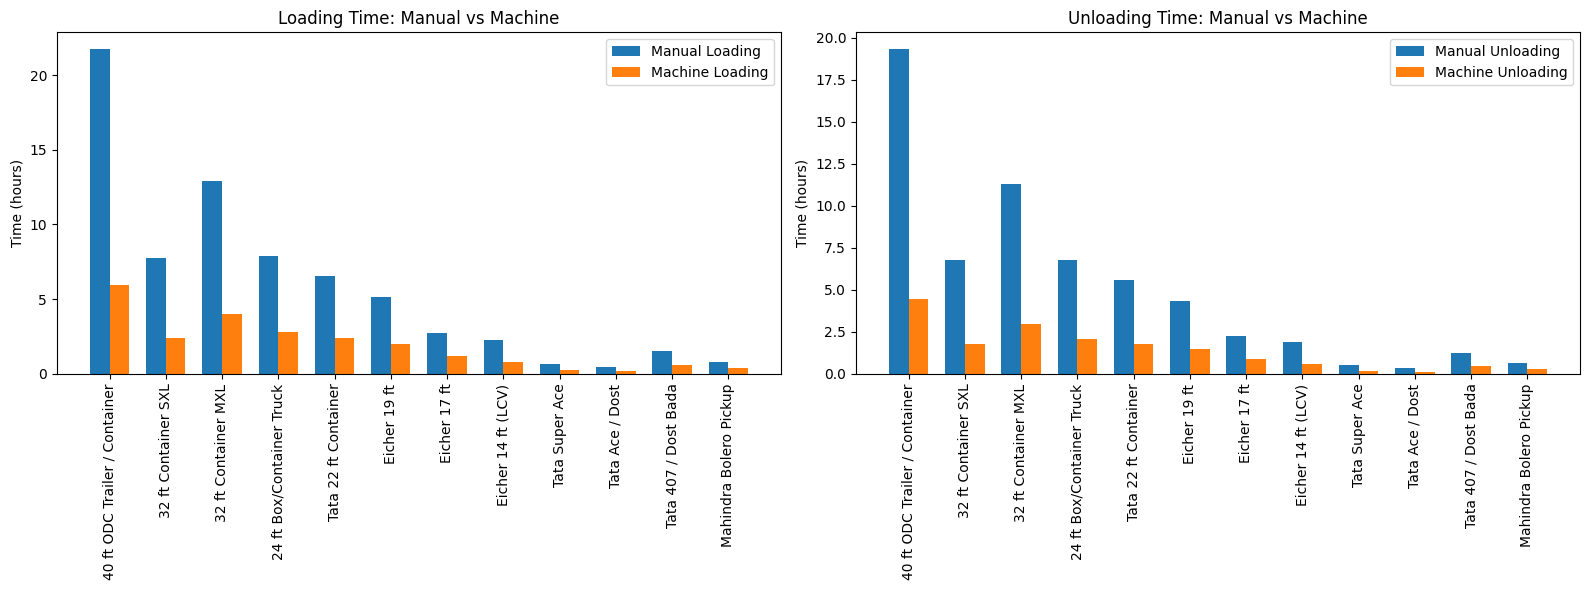

In [3]:
# 2. Constants
SPEED_WITHOUT_LOAD = 0.9   # m/s
SPEED_WITH_LOAD    = 0.67  # m/s
LOADING_DELAY      = 13.8  # s/parcel
UNLOADING_DELAY    = 10.21 # s/parcel

# 3. Compute times given parameters [f1,f2,f3,f4, alpha, tturn]
def compute_times(params):
    f1, f2, f3, f4, alpha, tturn = params
    manual_load, manual_unld = [], []
    machine_load, machine_unld = [], []
    
    for v in VEHICLES:
        n, L_ft = v['parcels'], v['L']
        # fatigue multiplier
        if   n <= 100: fm = f1
        elif n <= 200: fm = f2
        elif n <= 300: fm = f3
        else:           fm = f4

        # walking distance (m)
        d = L_ft * 0.3048 * alpha
        # walking time (hr)
        walk_hr = ((d / SPEED_WITHOUT_LOAD) + (d / SPEED_WITH_LOAD)) * n * fm / 3600
        # handling time (hr)
        load_hr = (LOADING_DELAY + tturn)   * n * fm / 3600
        unld_hr = (UNLOADING_DELAY + tturn) * n * fm / 3600
        # machine times (hr)
        machL = (LOADING_DELAY + tturn)   * n / 3600
        machU = (UNLOADING_DELAY + tturn) * n / 3600

        manual_load.append(walk_hr + load_hr)
        manual_unld.append(walk_hr + unld_hr)
        machine_load.append(machL)
        machine_unld.append(machU)
    
    return (np.array(manual_load),
            np.array(manual_unld),
            np.array(machine_load),
            np.array(machine_unld))

# 4. Loss function
def loss(params):
    mL, mU, _, _ = compute_times(params)
    errs = []
    for v, pL, pU in zip(VEHICLES, mL, mU):
        lbl = v['type']
        errs.append((pL - opt_loading[lbl])   / opt_loading[lbl])
        errs.append((pU - opt_unloading[lbl]) / opt_unloading[lbl])
    return np.mean(np.square(errs))

# 5. Optimize parameters
initial = [1.1, 1.2, 1.3, 1.4, 0.6, 2.0]  # f1,f2,f3,f4,alpha,tturn
bounds = [(1,2)]*4 + [(0.3,1.0), (0.5,5.0)]
res = minimize(loss, initial, bounds=bounds, method='L-BFGS-B')
f1, f2, f3, f4, alpha, tturn = res.x

print("▶ Optimized parameters:")
print(f"  f1 (≤100 parcels):     ×{f1:.3f}")
print(f"  f2 (≤200 parcels):     ×{f2:.3f}")
print(f"  f3 (≤300 parcels):     ×{f3:.3f}")
print(f"  f4 (>300 parcels):     ×{f4:.3f}")
print(f"  Length factor α:       ×{alpha:.3f}")
print(f"  Turning time tturn:    {tturn:.3f} s/parcel")
print(f"  Mean‐squared %‐error:  {res.fun:.6f}\n")

# 6. Recompute times
mL, mU, machL, machU = compute_times([f1, f2, f3, f4, alpha, tturn])

# 7. Build Error Table
error_rows = []
for v, pL, pU in zip(VEHICLES, mL, mU):
    lbl = v['type']
    optL, optU = opt_loading[lbl], opt_unloading[lbl]
    error_rows.append({
        "Vehicle": lbl,
        "Opt Load (h)": optL,
        "Calc Load (h)": round(pL,2),
        "Err Load (%)": round(abs(pL-optL)/optL*100,1),
        "Opt Unld (h)": optU,
        "Calc Unld (h)": round(pU,2),
        "Err Unld (%)": round(abs(pU-optU)/optU*100,1),
    })
error_df = pd.DataFrame(error_rows)

print("=== Error Table ===")
print(error_df.to_string(index=False))

# 8. Build Manual vs Auto Table
ma_rows = []
for v, pL, pU, ML, MU in zip(VEHICLES, mL, mU, machL, machU):
    lbl = v['type']
    ma_rows.append({
        "Vehicle": lbl,
        "Manual Load (h)": round(pL,2),
        "Machine Load (h)": round(ML,2),
        "% Save Load": round(100*(1-ML/pL),1),
        "Manual Unld (h)": round(pU,2),
        "Machine Unld (h)": round(MU,2),
        "% Save Unld": round(100*(1-MU/pU),1)
    })
ma_df = pd.DataFrame(ma_rows)

print("\n=== Manual vs Machine Table ===")
print(ma_df.to_string(index=False))

# 9. Plotting
x = np.arange(len(VEHICLES))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

# Loading plot
ax1.bar(x - width/2, mL, width, label="Manual Loading")
ax1.bar(x + width/2, machL, width, label="Machine Loading")
ax1.set_xticks(x)
ax1.set_xticklabels([v['type'] for v in VEHICLES], rotation=90)
ax1.set_ylabel("Time (hours)")
ax1.set_title("Loading Time: Manual vs Machine")
ax1.legend()

# Unloading plot
ax2.bar(x - width/2, mU, width, label="Manual Unloading")
ax2.bar(x + width/2, machU, width, label="Machine Unloading")
ax2.set_xticks(x)
ax2.set_xticklabels([v['type'] for v in VEHICLES], rotation=90)
ax2.set_ylabel("Time (hours)")
ax2.set_title("Unloading Time: Manual vs Machine")
ax2.legend()

plt.tight_layout()
plt.show()

## Globally and Locally Optimized Parameters

▶ Optimized parameters:
  f1–f4: 1.474, 1.661, 1.179, 1.226
  α (length factor): 0.582
  tturn (s): 1.283
  v_walk, v_load (m/s): 0.659, 0.377
  d_load, d_unld (s): 15.40, 7.89
  Mean‐squared %‐error: 0.008952

=== Error Table ===
                      Vehicle  Opt Load (h)  Calc Load (h)  Err Load (%)  Opt Unld (h)  Calc Unld (h)  Err Unld (%)
40 ft ODC Trailer / Container       24.0000          23.64           1.5       19.5000          19.80           1.5
          32 ft Container SXL        9.0000           8.25           8.4        7.0000           6.71           4.1
          32 ft Container MXL       15.0000          13.74           8.4       12.5000          11.18          10.5
    24 ft Box/Container Truck        9.0000           8.21           8.8        7.0000           6.42           8.3
         Tata 22 ft Container        6.1250           6.73           9.9        4.8125           5.20           8.0
                 Eicher 19 ft        4.5000           5.23          16.3 

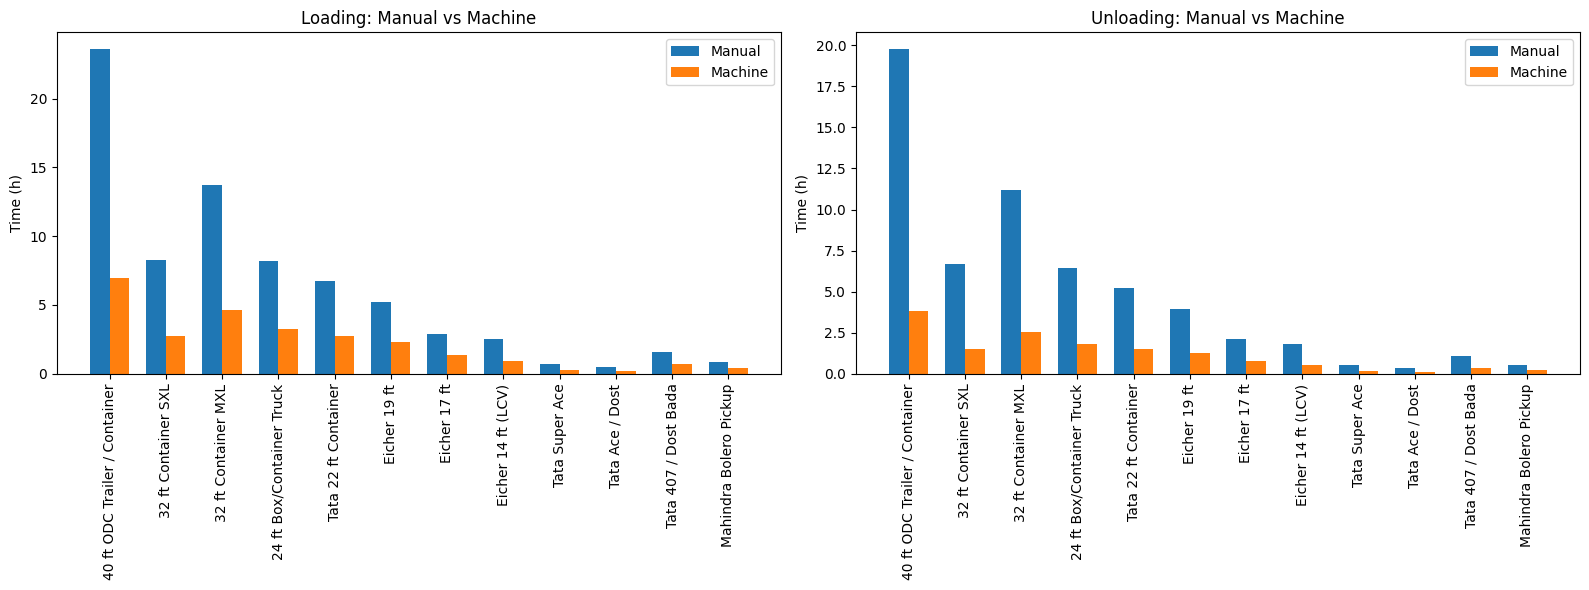

In [4]:
# 2. Compute times given all parameters as variables:
# params = [f1,f2,f3,f4, alpha, tturn, v_walk, v_load, delay_load, delay_unld]
def compute_times(params):
    f1, f2, f3, f4, alpha, tturn, v_walk, v_load, d_load, d_unld = params
    manual_load, manual_unld = [], []
    machine_load, machine_unld = [], []
    for v in VEHICLES:
        n, L_ft = v['parcels'], v['L']
        fm = f1 if n<=100 else f2 if n<=200 else f3 if n<=300 else f4
        d = L_ft * 0.3048 * alpha
        walk_hr = ((d/v_walk) + (d/v_load)) * n * fm / 3600
        load_hr = (d_load + tturn)   * n * fm / 3600
        unld_hr = (d_unld + tturn)  * n * fm / 3600
        machL = (d_load + tturn)   * n / 3600
        machU = (d_unld + tturn)   * n / 3600
        manual_load.append(walk_hr + load_hr)
        manual_unld.append(walk_hr + unld_hr)
        machine_load.append(machL)
        machine_unld.append(machU)
    return (np.array(manual_load),
            np.array(manual_unld),
            np.array(machine_load),
            np.array(machine_unld))

# 3. Loss = mean squared percentage error vs benchmarks
def loss(params):
    mL, mU, _, _ = compute_times(params)
    errs = []
    for v, pL, pU in zip(VEHICLES, mL, mU):
        lbl = v['type']
        errs.append((pL - opt_loading[lbl])   / opt_loading[lbl])
        errs.append((pU - opt_unloading[lbl]) / opt_unloading[lbl])
    return np.mean(np.square(errs))

# 4. Optimize all parameters
initial = [
    1.1, 1.2, 1.3, 1.4,    # f1–f4
    0.6,                   # alpha
    2.0,                   # tturn
    0.9,                   # v_walk
    0.67,                  # v_load
    13.8,                  # d_load
    10.21                  # d_unld
]
bounds = [
    (1.0, 2.0), (1.0, 2.0), (1.0, 2.0), (1.0, 2.0),  # f1–f4
    (0.3, 1.0),        # alpha
    (0.5, 5.0),        # tturn
    (0.5, 2.0),        # v_walk
    (0.3, 1.5),        # v_load
    (5.0, 20.0),       # d_load
    (5.0, 20.0)        # d_unld
]
res = minimize(loss, initial, bounds=bounds, method='L-BFGS-B')
f1,f2,f3,f4,alpha,tturn,v_walk,v_load,d_load,d_unld = res.x

print("▶ Optimized parameters:")
print(f"  f1–f4: {f1:.3f}, {f2:.3f}, {f3:.3f}, {f4:.3f}")
print(f"  α (length factor): {alpha:.3f}")
print(f"  tturn (s): {tturn:.3f}")
print(f"  v_walk, v_load (m/s): {v_walk:.3f}, {v_load:.3f}")
print(f"  d_load, d_unld (s): {d_load:.2f}, {d_unld:.2f}")
print(f"  Mean‐squared %‐error: {res.fun:.6f}\n")

# 5. Recompute with optimized params
mL, mU, machL, machU = compute_times(res.x)

# 6. Error Table
err_rows = []
for v, pL, pU in zip(VEHICLES, mL, mU):
    lbl = v['type']
    err_rows.append({
        "Vehicle": lbl,
        "Opt Load (h)": opt_loading[lbl],
        "Calc Load (h)": round(pL,2),
        "Err Load (%)": round(abs(pL-opt_loading[lbl])/opt_loading[lbl]*100,1),
        "Opt Unld (h)": opt_unloading[lbl],
        "Calc Unld (h)": round(pU,2),
        "Err Unld (%)": round(abs(pU-opt_unloading[lbl])/opt_unloading[lbl]*100,1)
    })
error_df = pd.DataFrame(err_rows)
print("=== Error Table ===")
print(error_df.to_string(index=False))

# 7. Manual vs Machine Table
ma_rows = []
for v, pL, pU, ML, MU in zip(VEHICLES, mL, mU, machL, machU):
    lbl = v['type']
    ma_rows.append({
        "Vehicle": lbl,
        "Manual Load (h)": round(pL,2),
        "Machine Load (h)": round(ML,2),
        "% Save Load": round(100*(1-ML/pL),1),
        "Manual Unld (h)": round(pU,2),
        "Machine Unld (h)": round(MU,2),
        "% Save Unld": round(100*(1-MU/pU),1)
    })
ma_df = pd.DataFrame(ma_rows)
print("\n=== Manual vs Machine Table ===")
print(ma_df.to_string(index=False))

# 8. Plotting
x = np.arange(len(VEHICLES))
w = 0.35
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))

# Loading
ax1.bar(x-w/2, mL, w, label="Manual")
ax1.bar(x+w/2, machL, w, label="Machine")
ax1.set_xticks(x); ax1.set_xticklabels([v['type'] for v in VEHICLES], rotation=90)
ax1.set_ylabel("Time (h)")
ax1.set_title("Loading: Manual vs Machine")
ax1.legend()

# Unloading
ax2.bar(x-w/2, mU, w, label="Manual")
ax2.bar(x+w/2, machU, w, label="Machine")
ax2.set_xticks(x); ax2.set_xticklabels([v['type'] for v in VEHICLES], rotation=90)
ax2.set_ylabel("Time (h)")
ax2.set_title("Unloading: Manual vs Machine")
ax2.legend()

plt.tight_layout()
plt.show()